In [1]:
# ! pip install cornac==1.15.4 --quiet adjustText

# Cat Adoption Recommender

A recommender system to improve the adoptability of rescue cats by curating adopter-specific cat recommendations. Using multimodal content-based filtering and deep learning methods, various recommender models were trained on cat images, textual descriptions, user ratings and implicit feedback to generate personalised recommendations based on the adopter’s preferences.

**Outline**
1. Data processing
2. Exploratory models for
    1. User interactions + item (cat) images
        1. Visual Matrix Factorisation (VMF)
        2. Visual Bayesian Personalised Ranking (VBPR)
        3. Causal Inference for Visual Debiasing in Visually-Aware Recommendation (CausalRec)
    2. User interactions + item (cat) text. Textual information includes the description of the cats.
        1. Collaborative Topic Regression (CTR)
        2. Convolutional Matrix Factorisation (ConvMF)
3. Best recommender model with hyperparameter tuning
4. Results

In [2]:
import sys

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px

import cornac
from cornac.data import ImageModality, TextModality
from cornac.data.text import BaseTokenizer
from cornac.hyperopt import Discrete, Continuous

import tensorflow as tf

import torch

print(f"Python version: {sys.version}")
print(f"Cornac version: {cornac.__version__}")
print(f"Tensorflow version: {tf.__version__}")
print(f"Pytorch version: {torch.__version__}")

sys.path.insert(1, '../scripts/')
from harmonic_mean import HarmonicMean
from serendipity_wrapper import Serendipity
from distributional_coverage_wrapper import DistributionalCoverage
from combined_eval_method import CombinedBaseMethod
from new_random_search import NewRandomSearch

SEED = 2023

FM model is only supported on Linux.
Windows executable can be found at http://www.libfm.org.
Python version: 3.9.16 (main, Mar  8 2023, 04:29:44) 
[Clang 14.0.6 ]
Cornac version: 1.15.4
Tensorflow version: 2.12.0
Pytorch version: 2.0.1


## 1. Data processing
There are 3 main datasets
1. **User data** which includes user-item interactions (e.g. likes, clicks, dwell time). Collected through a custom-made application.
2. **Cat image vectors**. From <a href="https://www.catwelfare.org/adoptions/">Cat Welfare Society's (CWS) adoption board</a>.
3. **Text descriptions of the cats**. From <a href="https://www.catwelfare.org/adoptions/">Cat Welfare Society's (CWS) adoption board</a>.

### 1.1 User data

**Features**
1. `id`. unique ID for each user-cat pair.
2. `catID`. unique ID for each cat.
3. `userID`. unique ID for each user.
4. `like`. User interaction which indicates True if a particlur user clicks the "like" button for that cat.
5. `dwell_time_ms`. User interaction which indicates the amount of time (ms) spent by that user on that cat profile.
6. `click`. User interaction which indicates whether that user has clicked into cat profile.

In [3]:
SPLIT_TYPE = 'stratified_split'

# Import user data
train = pd.read_csv('../data/train_val_test/'+SPLIT_TYPE+'/train.csv', index_col='id')
validation = pd.read_csv('../data/train_val_test/'+SPLIT_TYPE+'/validation.csv', index_col='id')
test = pd.read_csv('../data/train_val_test/'+SPLIT_TYPE+'/test.csv', index_col='id')

data = {'train': train, 'validation': validation, 'test': test}

**Feature engineering**

We create an additional field, `weighted_rating` that incoporates all user interactions (i.e. `like`, `dwell_time_ms`, `click`) as a weighted score.

In [4]:
from sklearn.preprocessing import MinMaxScaler

# Instantiate MinMaxScaler to scale dwell_time_log within 0 and 1
min_max_scaler = MinMaxScaler()

# Set weights for like, click and dwell time
like_weight=0.6
click_weight=0.2
dwell_weight=0.2

for name,df in data.items():
    data[name]['like'] = data[name]['like'].apply(lambda x: 1 if x==True else 0)    # Convert True/False to 1/0
    data[name]['click'] = data[name]['click'].apply(lambda x: 1 if x==True else 0)  # Convert True/False to 1/0
    data[name]['dwell_time_log'] = data[name]['dwell_time_ms'].apply(lambda x: np.log(x))

    if name=='train':   # For training set, fit the scaler
        data[name]['normalized_dwell_time'] = min_max_scaler.fit_transform(data[name][['dwell_time_log']])
        
    else:
        # For validation and test set, apply the fitted scaler
        data[name]['normalized_dwell_time'] = min_max_scaler.transform(data[name][['dwell_time_log']])
        # Clip normalized_dwell_time to between 0 and 1
        data[name]['normalized_dwell_time'] = data[name]['normalized_dwell_time'].apply(lambda x: 0 if x<0 else x)
        data[name]['normalized_dwell_time'] = data[name]['normalized_dwell_time'].apply(lambda x: 1 if x>1 else x)


    # Create weighted_rating field
    data[name]['weighted_rating'] =  like_weight*data[name]['like'] + click_weight*data[name]['click'] + dwell_weight*data[name]['normalized_dwell_time']

    # Keep only necessary columns
    data[name] = data[name][['userID','catID','like','weighted_rating']]

In [5]:
# For each of the train, validation and test sets,
# Prepare data in this format: [(user i, item j, TARGET),...] (where target can be the column like or weighted_rating)

TARGET = 'weighted_rating'
# TARGET = 'like'

for name,df in data.items():
    data[name] = data[name][['userID','catID',TARGET]]
    data[name] = list(data[name].itertuples(index=False, name=None))
    
    # If we are using the like column, keep only rows where like==1 (i.e. True)
    # This is because cornac's CausalRec​ and VBPR utilizes the uij_iter​ function, which samples negative items j​ for each positive item i​.
    # However, the negative items should not appear in the feedback​ matrix
    if TARGET=='like':
        data[name] = [(tup[0], tup[1], 1) for tup in data[name] if tup[2]]


train, validation, test = data['train'], data['validation'], data['test']

### 1.2 Image preprocessing

#### 1.2.1 Load cat images

In [6]:
df_img = pd.read_pickle('../data/auxiliary/cat_images.pkl')
df_img.rename(columns={'id':'catID', 'cws_id':'cwsID'}, inplace = True)
df_img.sort_values(by=['catID'], inplace = True)

catID = df_img['catID'].to_list()

#### 1.2.2 Preprocess image vectors

In [7]:
new_size = [128, 128, 3]

# Function to remap vectors from a list to array
def list_to_arr(str_list):
    # split the stringed list
    arr = [float(num.strip(',')) for num in str_list[1:-1].split()]
    arr = np.array(arr)
    return arr

# Process image vectors for visualisation
df_img['img_vector'] = df_img['img_vector'].map(list_to_arr)
df_img['img_vector'] = df_img['img_vector'].apply(lambda x: np.array(x).reshape(new_size))
df_img['img_vector'] = df_img['img_vector'].apply(lambda x: x.astype(np.float32))

#### 1.2.3 Feature extraction using pretrained model
We will use `MobileNetV2`.

In [8]:
# Instantiate MobileNetv2
mnetv2_base = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(new_size), include_top=False, weights='imagenet')
# Freeze layers
for layer in mnetv2_base.layers:
    layer.trainable = False

# Function to extract features
def img_feature_extraction(img_vectors, pre_model):
    batch_img = []
    # preprocessing and then using pretrained model to extract features
    for image in img_vectors:
        im_toarray = tf.keras.preprocessing.image.img_to_array(image)
        im_toarray = np.expand_dims(image, axis=0)
        im_toarray = tf.keras.applications.mobilenet.preprocess_input(im_toarray)
        batch_img.append(im_toarray)

    batch_img = np.vstack(batch_img)
    features = pre_model.predict(batch_img, batch_size=64)
    features = features.reshape((len(img_vectors), -1))
    return features

In [9]:
# Extract image features
img_features = img_feature_extraction(df_img['img_vector'], mnetv2_base)
print(f"The shape of the img_features array is {img_features.shape}")

7/7 [==============================] - 4s 373ms/step
The shape of the img_features array is (404, 20480)


### 1.3 Text preprocessing

#### 1.3.1 Load text description of cats

In [10]:
df_cats = pd.read_csv('../data/auxiliary/cats.csv')
df_cats.sort_values(by=['id'], inplace = True)  # Sort by catID

#### 1.3.2 Preprocess text columns

In [11]:
import re
import contractions
from nltk.tokenize import word_tokenize
from num2words import num2words

# Helper function to convert numbers to words
def numbers_to_words(text):
    output = word_tokenize(text)    # Split into words
    # Check each word. If it is a number, convert to number
    for i in range(len(output)):
        if output[i].isnumeric():
            try:
                output[i] = num2words(output[i])
            except:
                pass
    # Join the words to form the original paragraph
    output = ' '.join(output)
    
    return output

# Helper function to clean up spaces before punctuation
def clean_punc(text):
    return re.sub(r'\s+([!\.\?:,])', r'\1', text)

# Actual function for text preprocessing
def text_preprocessing(df, column_name):
    # Collapse multiple new lines into 1 new line
    df[column_name] = df[column_name].apply(lambda x: re.sub(r'\n+', r'\n', x))
    # Expand contractions (e.g. can't to cannot)
    df[column_name] = df[column_name].apply(lambda x: contractions.fix(x))
    # Convert number to words
    df[column_name] = df[column_name].apply(lambda x: numbers_to_words(x))
    # Clean up spaces before punctuation
    df[column_name] = df[column_name].apply(lambda x: clean_punc(x))
    return df


In [12]:
# Preprocess description column
df_cats = text_preprocessing(df_cats,'description')

# Preprocess details column
df_cats = text_preprocessing(df_cats,'details')

In [13]:
# Get the number of words in details column
def get_length(text):
    output = word_tokenize(text)
    return len(output)

df_cats['review_length'] = df_cats['details'].apply(lambda x: get_length(x))

# Visualise the distribution of the review length

fig = px.box(df_cats, x='review_length',
             title='Number of words in the details')
fig.show()

In [14]:
# Preprocess description column

# Replace "no description avaliable" with "none"
df_cats['description'].replace("no description available", "none", inplace=True)

# Replace "likes to be held" with "cuddly"
# df_cats['description'].replace("likes to be held", "cuddly", inplace=True)
df_cats['description'] = df_cats['description'].apply(lambda x: re.sub(r'likes to be held', 'cuddly', x))

# Replace "loves attention" with "demanding"
df_cats['description'] = df_cats['description'].apply(lambda x: re.sub(r'loves attention', 'demanding', x))

df_cats['description'].head(10)

89     curious, talkative, sweet
231       playful, loving, sweet
17                          none
106           playful, talkative
29                   loving, shy
133     loving, sweet, demanding
175       active, curious, sweet
273                loving, sweet
187       playful, loving, sweet
196                         none
Name: description, dtype: object

In [15]:
# Convert fields to list
text_desc = df_cats['description'].to_list()
text_details = df_cats['details'].to_list()

In [16]:
# Get max nnumber of words
max_desc_length = max(df_cats['description'].apply(lambda x: len(word_tokenize(x))))
max_details_length = max(df_cats['details'].apply(lambda x: len(word_tokenize(x))))
max_text_length = max(max_desc_length, max_details_length)

max_text_length

1019

#### 1.3.3 Feature extraction for textual description and details
Refer to Eskandar (2023)</a><sup id="intext3">[3](#f3)</sup> for details on the appropriate feature extraction methods for text.

##### 1.3.3.2 Extracting features from `description` using **tf-idf**
`description` is a short summary of cat traits (e.g. curious, sweet, shy etc.). Hence, we will extract word embeddings.

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = text_desc

vectorizer = TfidfVectorizer()
text_desc_features = vectorizer.fit_transform(corpus)

# Convert the if-idf matrix to array
text_desc_features = text_desc_features.toarray()

print(f"The shape of the text_desc_features array is {text_desc_features.shape}")

# See the words
vectorizer.get_feature_names_out()

The shape of the text_desc_features array is (404, 13)


array(['active', 'cuddly', 'curious', 'demanding', 'friendly', 'loving',
       'none', 'playful', 'quiet', 'shy', 'spicy', 'sweet', 'talkative'],
      dtype=object)

In [18]:
# Combine text_details and image features
text_desc_img = np.concatenate((text_desc_features,img_features), axis=1)

print(f"The shape of the img_features is {img_features.shape}")
print(f"The shape of the text_desc_features is {text_desc_features.shape}")
print(f"The shape of the combined vectors is {text_desc_img.shape}")

The shape of the img_features is (404, 20480)
The shape of the text_desc_features is (404, 13)
The shape of the combined vectors is (404, 20493)


##### 1.3.3.2 Extracting features from `details` using **MPNet**

`details` is a longer writeup of the cat's description. Therefore, we will use a Large Langague Model to vectorise it.

MPNet combines the best of BERT and XLNet. It is the best performing pretrained model in the `sentence-transformers` <a href="https://www.sbert.net/docs/pretrained_models.html">model library</a>.

In [19]:
from transformers import AutoTokenizer, AutoModel

# Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]  # First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

# Sentences we want sentence embeddings for
inputs = text_details

# Load AutoModel from huggingface model repository
model_name = 'all-mpnet-base-v2'
tokenizer = AutoTokenizer.from_pretrained(f"sentence-transformers/{model_name}")
model = AutoModel.from_pretrained(f"sentence-transformers/{model_name}")

# Tokenize sentences
encoded_input = tokenizer(
    inputs,             # List of input texts
    padding=True,       # Padding to standardise tensor size
    truncation=True,    # Truncate to the maximum sequence length if necessary
    max_length=512,     # Adjust sentence length
    return_tensors='pt' # Return PyTorch tensors
    )

# Compute token embeddings
with torch.no_grad():
    model_output = model(**encoded_input)

# Perform pooling. In this case, mean pooling
text_details_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

# Convert tensor into numpy array
text_details_features = text_details_embeddings.numpy()

print(f"The shape of the text_details_features array is {text_details_features.shape}")

The shape of the text_details_features array is (404, 768)


In [20]:
# Combine text_details and image features
text_details_img = np.concatenate((text_details_features,img_features), axis=1)

print(f"The shape of the img_features is {img_features.shape}")
print(f"The shape of the text_details_features is {text_details_features.shape}")
print(f"The shape of the combined vectors is {text_details_img.shape}")

The shape of the img_features is (404, 20480)
The shape of the text_details_features is (404, 768)
The shape of the combined vectors is (404, 21248)


## 3. Build models

In [21]:
# To store the experiments
experiments = []

# Helper function to output recommendations
def make_recommendations(model, data, target=TARGET):
    # Define mappings
    item_id2idx = model.train_set.iid_map
    item_idx2id = list(model.train_set.item_ids)
    user_id2idx = model.train_set.uid_map
    user_idx2id = list(model.train_set.user_ids)

    # Make data into df
    data = pd.DataFrame(train, columns=['userID','catID',target])


    data = pd.merge(left=data, right=df_cats[['id','description']], how='left', left_on='catID', right_on='id')
    data.drop(columns=['id'], inplace=True)

    # Replace "none" with "no description avaliable"
    data['description'].replace("none", "no description available", inplace=True)
    # Replace "cuddly" with "likes to be held"
    data['description'] = data['description'].apply(lambda x: re.sub(r'cuddly', 'likes to be held', x))
    # Replace "demanding" with "loves attention"
    data['description'] = data['description'].apply(lambda x: re.sub(r'demanding', 'loves attention', x))
    
    # Get number of users
    num_users = len(np.unique(user_idx2id))
      
    # For each user, get the list of items that they have rated before
    rated_items = data.groupby('userID')['catID'].agg(lambda x: list(x))
    rated_items = rated_items.to_dict()

    # Get recommendations and store in this format {userID:[catID1, catID2...]]}
    recommendations = {}
    # For each user, get the recommended itemIDs
    for user_idx in range(num_users):
        user_recommendations, scores = model.rank(user_idx)
        userID = user_idx2id[user_idx]
        recommendations[userID] = [item_idx2id[i] for i in user_recommendations]

    # Sort results
    recommendations = {userID:user_recommendations for userID,user_recommendations in sorted(recommendations.items(), key=lambda item: item[0])}

    # For each user, remove the items that they have rated before
    for userID, user_recommendations in recommendations.items():
        recommendations[userID] = [itemID for itemID in user_recommendations if itemID not in rated_items[userID]]

    return rated_items, recommendations


# Helper function to visualise rated and recommended items
def show_results(userID, data):
    grid_l, grid_h = 4, 4
    samples = grid_l*grid_h

    # Use original text descriptions
    # Replace "none" with "no description avaliable"
    df_cats['description'].replace("none", "no description available", inplace=True)
    # Replace "cuddly" with "likes to be held"
    df_cats['description'] = df_cats['description'].apply(lambda x: re.sub(r'cuddly', 'likes to be held', x))
    # Replace "demanding" with "loves attention"
    df_cats['description'] = df_cats['description'].apply(lambda x: re.sub(r'demanding', 'loves attention', x))

    # For a particular userID, prepare the data as images and labels
    # Labels are the catIDs associated with a userID
    items = data[userID]
    images = []
    texts = []

    for item in items:
        # Extract image vectors
        img = df_img.loc[df_img['catID']==item,'img_vector'].iloc[0]
        img = (img - np.min(img)) / (np.max(img) - np.min(img)) # Normalize
        images.append(img)

        # Extract text desciptions
        text = df_cats.loc[df_cats['id']==item, 'description'].iloc[0]
        texts.append(text)

    # Combine catID and description to form the label
    labels = [f'{items[i]} \n {texts[i]}' for i in range(len(items))]

    # Plot the images in a grid
    plt.figure(figsize=(grid_l*2, grid_h*2))
    for i in range(samples):
        plt.subplot(grid_h,grid_l,i+1)
        plt.imshow(images[i])
        plt.axis('off')
        plt.title(labels[i], fontsize = 6)
        plt.tight_layout()
    plt.show()

    # Extract only the relevant rows from df_cats
    traits = ['playful', 'active', 'curious', 'talkative', 'quiet', 'loving', 'sweet', 'likes_held', 'friendly', 'shy', 'spicy', 'loves_attention']
    df_cats_user = df_cats[df_cats['id'].isin(items)][traits]

    # Rename columns
    df_cats_user.rename(columns={'likes_held':'likes to be held', 'loves_attention':'loves attention'}, inplace=True)
    traits = df_cats_user.columns

    # Convert True/False into 1/0
    df_cats_user.replace(True, 1, inplace=True)
    df_cats_user.replace(False, 0, inplace=True)

    # Pivot dataframe
    df_cats_user = df_cats_user.melt(value_vars=traits, var_name='traits', value_name='count')
    df_cats_user = df_cats_user[df_cats_user['count']!=0] # Drop redundant rows

    # Plot count plot of user's preferred traits
    fig = px.histogram(df_cats_user, x='traits',
                       title='Preferred traits',
                       height=400, width=800)
    fig.show()
   

### 3.1 Evaluation metrics and methods

We will use the **harmonic mean of the following metrics** to evaluate model performance
1. `f2@10`, the harmonic mean of precision and recall out of top 10 items
2. `NCRR` (Normalized Cumulative Reciprocal Rank), which accounts for both the relevance and the position of each recommended item in the ranked list. Higher NCRR values mean better quality recommendations.
3. `NDCG` (Normalized Discounted Cumulative Gain), which accounts for both the relevance and the position of each recommended item in the ranked list. This is similar to NCRR, but is discounted by its position. Higher NDCG values mean better quality recommendations.
4. `serendipity`, a measure of “surprisingly relevant” recommendations.

<blockquote>

**Serendipity** represents the “unusualness” or “surprise” of recommendations. <sup id="intext2">[2](#f2)</sup> <sup id="intext4">[4](#f4)</sup> <sup id="intext5">[5](#f5)</sup>
$$
\textrm{serendipity} = \frac{1}{|M|} \sum_{u \in M_r}
\frac{1}{|N_r (u)|} \sum_{i \in N_r (u)} \big(1 - \textrm{expectedness}(i|u) \big) \, \textrm{relevance}(i)
$$

where $M$ is the set of users and $N_r(u)$ the set of recommendations for user $u$.


The **expectedness** of an unseen item $i$ for user $u$ as the average similarity between every already seen item $j$ in the historical data and $i$ can be defined as
$$
\textrm{expectedness}(i|u) = \frac{1}{|N_t (u)|} \sum_{j \in N_t (u)} \textrm{Cosine Similarity}(i,j)
$$

and **relevance** indicates whether the item turns out to be liked by the user or not

$$
\textrm{relevance}(i)=
\begin{cases}
  1 & \text{if } i \text{ in recommendations set is liked by a user } u \text{ in test set}\\    
  0 & \text{otherwise}   
\end{cases}
$$
</blockquote>

5. `distributional_coverage`, a measure of how equally different items are recommended.

<blockquote>

**Distributional coverage** measures how equally different items are recommended to users. <sup id="intext2">[2](#f2)</sup>
$$
\textrm{DistributionalCoverage} = -\sum_{i \in N_t} p(i|R) \log_2 p(i)
$$
where $p(i|R)$ denotes the probability that item $i$ is observed among all recommendation lists. 

$$
p(i|R) = \frac{|M_r (i)|}{|\textrm{recommendations}|}
$$
and $M_r (i)$ denotes the users who are recommended item $i$. The more unexpected or low-probability items are recommended, the higher the distributional_coverage score will be.
</blockquote>

To incorporate `serendipity` and `distributional_coverage`, we create a wrapper over Microsoft's `recommenders`' <a href="https://github.com/recommenders-team/recommenders/blob/main/recommenders/evaluation/python_evaluation.py" target="-blank">evaluation metrics</a><sup id="intext3">[3](#f3)</sup>.

In [22]:
# Instantiate harmonic mean
harmonic_mean = HarmonicMean(
    -1, # k
    Serendipity(),
    DistributionalCoverage(),
    cornac.metrics.FMeasure(k=10),
    cornac.metrics.NCRR(),
    cornac.metrics.NDCG()
    )

# Define evaluation metrics
eval_metrics = [
    harmonic_mean,                  # Returns the average harmonic mean of all metrics over users 
    Serendipity(),
    DistributionalCoverage(),       
    cornac.metrics.FMeasure(k=10),
    cornac.metrics.NCRR(),
    cornac.metrics.NDCG()
]

### 3.2 Models for interactions and images

In [23]:
modality = 'image'

# When working with images, cornac allows us to instantiate ImageModality to make it convenient to work with visual auxiliary information
item_image_modality = ImageModality(features=img_features, ids=catID, normalized=True)

# Define an evaluation method to split feedback into train, validation and test sets
bm = CombinedBaseMethod.from_splits(
    train_data=train,
    test_data=test,
    val_data=validation,
    rating_threshold=0.6,   # The threshold to convert ratings into positive or negative feedback.
    exclude_unknowns=SPLIT_TYPE=='stratified_split', # True when using stratified split, False when using leave some users out
    verbose=True,
    item_image=item_image_modality,
)

creating from splits
initialising Combined Base
rating_threshold = 0.6
exclude_unknowns = True
---
Training data:
Number of users = 104
Number of items = 400
Number of ratings = 3874
Max rating = 1.0
Min rating = 0.0
Global mean = 0.4
---
Test data:
Number of users = 100
Number of items = 195
Number of ratings = 487
Number of unknown users = 0
Number of unknown items = 0
---
Validation data:
Number of users = 96
Number of items = 184
Number of ratings = 476
---
Total users = 104
Total items = 400


#### 3.2.1 Visual Matrix Factorisation (VMF)

In [24]:
# Instantiate model
vmf = cornac.models.VMF(
    name=f"VMF_{modality}",
    k=10,
    d=10,
    n_epochs=20,
    batch_size=100,
    learning_rate=0.001,
    gamma=0.9,        # weight for previous/current gradient in RMSProp
    lambda_u=0.001,   # regularization parameter for user factors
    lambda_v=0.001,   # regularization parameter for item factors
    lambda_p=1.0,     # regularization parameter for user visual factors
    lambda_e=10.0,    # regularization parameter for the kernel embedding matrix
    use_gpu=True,
    verbose=False,
    # seed=SEED
)

# Find best parameters using RandomSearch
rs_vmf = NewRandomSearch(
    model=vmf,
    space=[
        Discrete("k", [10, 20, 50, 100]),
        Discrete("d", [10, 20, 50, 100]),
        Continuous("learning_rate", low=0.001, high=1.0),
        Continuous("gamma", low=0.5, high=1.0),
        Continuous("lambda_u", low=0.001, high=10.0),
        Continuous("lambda_v", low=0.001, high=100.0),
        Continuous("lambda_p", low=0.001, high=100.0),
        Continuous("lambda_e", low=0.001, high=100.0),
    ],
    # Optimise on harmonic mean
    metric=harmonic_mean,
    eval_method=bm,
    n_trails=20,
)

#### 3.2.2 Visual Bayesian Personalized Ranking (VBPR)

In [25]:
# Instantiate model
vbpr = cornac.models.VBPR(
    name=f"VBPR_{modality}",
    k=10,                   # dimension of the gamma latent factors
    k2=10,                  # dimension of the tetha latent factors
    n_epochs=20,
    batch_size=100,
    learning_rate=0.005,
    lambda_w=0.01,          # regularization hyperparameter for latent factor weights
    lambda_b=0.01,          # regularization hyperparameter for biases
    lambda_e=0.0,           # regularization hyperparameter for embedding matrix E and beta prime vector
    use_gpu=True,
    verbose=False,
    # seed=SEED
)

# Find best parameters using RandomSearch
rs_vbpr = NewRandomSearch(
    model=vbpr,
    space=[
        Discrete("k", [10, 20, 50, 100]),
        Discrete("k2", [10, 20, 50, 100]),
        Continuous("learning_rate", low=0.001, high=1.0),
        Continuous("lambda_w", low=0.001, high=10.0),
        Continuous("lambda_b", low=0.001, high=100.0),
        Continuous("lambda_e", low=0.001, high=100.0),
    ],
    # Optimise on harmonic mean
    metric=harmonic_mean,
    eval_method=bm,
    n_trails=20
)

#### 3.2.3 CausalRec

In [26]:
# Instantiate model
causalrec = cornac.models.CausalRec(
    name=f"CausalRec_{modality}",
    k=32,                                   # dimension of the gamma latent factors
    k2=32,                                  # dimension of the theta latent factors
    n_epochs=20,    
    batch_size=100,                         # batch size for SGD
    learning_rate=0.001,                    # learning rate for SGD
    lambda_w=1,                             # regularization hyperparameter for latent factor weights
    lambda_b=0.01,                          # regularization hyperparameter for biases
    lambda_e=0.0,                           # regularization hyperparameter for embedding matrix E and beta prime vector
    mean_feat=img_features.mean(axis=0),    # The mean feature of all item embeddings serving as the no-treatment during causal inference
    tanh=1,                                 # The number of tanh layers on the visual feature transformation
    lambda_2=0.8,                           # coefficient controlling the elimination of the visual bias
    use_gpu=True,
    trainable=True,
    verbose=False,
    # seed=SEED
)

# Find best parameters using RandomSearch
rs_causalrec = NewRandomSearch(
    model=causalrec,
    space=[
        Discrete("k", [10, 20, 30, 50, 100]),
        Discrete("k2", [10, 20, 30, 50, 100]),
        Continuous("learning_rate", low=0.001, high=1.0),
        Continuous("lambda_w", low=1, high=100.0),
        Continuous("lambda_b", low=0.01, high=100.0),
        Continuous("lambda_e", low=0.00, high=100.0),
        Discrete("tanh", [0, 1]),
        Continuous("lambda_2", low=0.01, high=100.0)
    ],
    # Optimise on harmonic mean
    metric=harmonic_mean,
    eval_method=bm,
    n_trails=20
)

In [27]:
# Put everything into an experiment and run it
experiment_image = cornac.Experiment(eval_method=bm, models=[rs_vmf, rs_vbpr, rs_causalrec], metrics=eval_metrics, user_based=False, save_dir="../models")
experiment_image.run()
experiments.append(experiment_image)


[RandomSearch_VMF_image] Training started!
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)

[RandomSearch_VMF_image] Evaluation started!


Ranking:   0%|          | 0/100 [00:00<?, ?it/s]

Ranking:   0%|          | 0/96 [00:00<?, ?it/s]


[RandomSearch_VBPR_image] Training started!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!

[RandomSearch_VBPR_image] Evaluation started!


Ranking:   0%|          | 0/100 [00:00<?, ?it/s]

Ranking:   0%|          | 0/96 [00:00<?, ?it/s]


[RandomSearch_CausalRec_image] Training started!


/Users/sx/opt/anaconda3/envs/cs608/lib/python3.9/site-packages/cornac/models/causalrec/recom_causalrec.py:240: UserWarning:

Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:248.)



Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!

[RandomSearch_CausalRec_image] Evaluation started!


Ranking:   0%|          | 0/100 [00:00<?, ?it/s]

Ranking:   0%|          | 0/96 [00:00<?, ?it/s]


VALIDATION:
...
                             | DistributionalCoverage |  F1@10 | HarmonicMean | NCRR@-1 | NDCG@-1 | Serendipity | Time (s)
---------------------------- + ---------------------- + ------ + ------------ + ------- + ------- + ----------- + --------
RandomSearch_VMF_image       |                 8.4759 | 0.0096 |       0.0050 |  0.0230 |  0.1912 |      0.0091 |   8.7899
RandomSearch_VBPR_image      |                 8.4759 | 0.0379 |       0.0125 |  0.0751 |  0.2604 |      0.0091 |   6.9653
RandomSearch_CausalRec_image |                 8.4759 | 0.0288 |       0.0094 |  0.0578 |  0.2399 |      0.0091 |   5.6618

TEST:
...
                             | DistributionalCoverage |  F1@10 | HarmonicMean | NCRR@-1 | NDCG@-1 | Serendipity | Train (s) | Test (s)
---------------------------- + ---------------------- + ------ + ------------ + ------- + ------- + ----------- + --------- + --------
RandomSearch_VMF_image       |                 8.4924 | 0.0046 |       0.0021 |  0.0141

### 3.3 Models for interactions and text

In [28]:
modality = 'textdesc'

# When working with text, cornac allows us to instantiate TextModality to make it convenient to work with textual auxiliary information
item_text_modality = TextModality(
    corpus=text_desc,
    ids=catID,
    tokenizer=BaseTokenizer(sep=" ", stop_words="english"),
    max_vocab=max_text_length,
    max_doc_freq=0.5,
)

# Define an evaluation method to split feedback into train, validation and test sets
bm = CombinedBaseMethod.from_splits(
    train_data=train,
    test_data=test,
    val_data=validation,
    rating_threshold=0.6,   # The threshold to convert ratings into positive or negative feedback.
    exclude_unknowns=SPLIT_TYPE=='stratified_split', # True when using stratified split, False when using leave some users out
    verbose=True,
    item_text=item_text_modality,
)

creating from splits
initialising Combined Base
rating_threshold = 0.6
exclude_unknowns = True
---
Training data:
Number of users = 104
Number of items = 400
Number of ratings = 3874
Max rating = 1.0
Min rating = 0.0
Global mean = 0.4
---
Test data:
Number of users = 100
Number of items = 195
Number of ratings = 487
Number of unknown users = 0
Number of unknown items = 0
---
Validation data:
Number of users = 96
Number of items = 184
Number of ratings = 476
---
Total users = 104
Total items = 400


#### 3.3.1 Collaborative Topic Regression (CTR)

In [29]:
# Instantiate model
ctr = cornac.models.CTR(
    name=f"CTR_{modality}",
    k=250,
    max_iter=200,
    lambda_v=1,
    verbose=False,
    # seed=SEED
    )

# Find best parameters using RandomSearch
rs_ctr = NewRandomSearch(
    model=ctr,
    space=[
        Discrete("k", [50, 75, 100, 150, 200]),
        Continuous("lambda_u", low=1e-4, high=1e1),
        Continuous("lambda_v", low=1e-4, high=1e1),
        Continuous("a", low=0.9, high=1),
        Continuous("b", low=0.0, high=0.1),
        Continuous("eta", low=0.001, high=0.1),
    ],
    # Optimise on harmonic mean
    metric=harmonic_mean,
    eval_method=bm,
    n_trails=20
)


#### 3.3.2 Convolutional Matrix Factorization (ConvMF)

In [30]:
# Instantiate model
convmf = cornac.models.ConvMF(
    name=f"ConvMF_{modality}",
    n_epochs=50,
    cnn_epochs=5,
    verbose=False,
    # seed=SEED
    )

# Find best parameters using RandomSearch
rs_convmf = NewRandomSearch(
    model=convmf,
    space=[
        Discrete("k", [50, 75, 100, 150, 200]),
        Continuous("lambda_u", low=1e-4, high=1e1),
        Continuous("lambda_v", low=1e-4, high=1e1),
        Continuous("a", low=0.9, high=1),
        Continuous("b", low=0.0, high=0.1),
        Continuous("eta", low=0.001, high=0.1),
    ],
    # Optimise on harmonic mean
    metric=harmonic_mean,
    eval_method=bm,
    n_trails=20
)

In [31]:
# Put everything into an experiment and run it
experiment_textdesc = cornac.Experiment(
    eval_method=bm, models=[rs_ctr, rs_convmf],
    metrics=eval_metrics,
    user_based=False,
    # save_dir="../models",     # text models can't be saved because of the lambda function in cornac.data.text
    )
experiment_textdesc.run()
experiments.append(experiment_textdesc)


[RandomSearch_CTR_textdesc] Training started!

[RandomSearch_CTR_textdesc] Evaluation started!


Ranking:   0%|          | 0/100 [00:00<?, ?it/s]

Ranking:   0%|          | 0/96 [00:00<?, ?it/s]


[RandomSearch_ConvMF_textdesc] Training started!

[RandomSearch_ConvMF_textdesc] Evaluation started!


Ranking:   0%|          | 0/100 [00:00<?, ?it/s]

Ranking:   0%|          | 0/96 [00:00<?, ?it/s]


VALIDATION:
...
                             | DistributionalCoverage |  F1@10 | HarmonicMean | NCRR@-1 | NDCG@-1 | Serendipity | Time (s)
---------------------------- + ---------------------- + ------ + ------------ + ------- + ------- + ----------- + --------
RandomSearch_CTR_textdesc    |                 8.4759 | 0.0472 |       0.0153 |  0.0847 |  0.2750 |      0.0091 |   4.5989
RandomSearch_ConvMF_textdesc |                 8.4759 | 0.0249 |       0.0091 |  0.0532 |  0.2294 |      0.0091 |   4.6936

TEST:
...
                             | DistributionalCoverage |  F1@10 | HarmonicMean | NCRR@-1 | NDCG@-1 | Serendipity | Train (s) | Test (s)
---------------------------- + ---------------------- + ------ + ------------ + ------- + ------- + ----------- + --------- + --------
RandomSearch_CTR_textdesc    |                 8.4924 | 0.0370 |       0.0147 |  0.0671 |  0.2525 |      0.0084 | 1185.5842 |   5.5246
RandomSearch_ConvMF_textdesc |                 8.4924 | 0.0074 |       0.00

### 3.4. Models for interactions, images and text description

In [32]:
modality = 'image_and_textdesc'

# Images + text_desc
item_text_desc_image_modality = ImageModality(features=text_desc_img, ids=catID, normalized=True)

# Define an evaluation method to split feedback into train, validation and test sets
bm = CombinedBaseMethod.from_splits(
    train_data=train,
    test_data=test,
    val_data=validation,
    rating_threshold=0.6,   # The threshold to convert ratings into positive or negative feedback.
    exclude_unknowns=SPLIT_TYPE=='stratified_split', # True when using stratified split, False when using leave some users out
    verbose=True,
    item_image=item_text_desc_image_modality,
)

creating from splits
initialising Combined Base
rating_threshold = 0.6
exclude_unknowns = True
---
Training data:
Number of users = 104
Number of items = 400
Number of ratings = 3874
Max rating = 1.0
Min rating = 0.0
Global mean = 0.4
---
Test data:
Number of users = 100
Number of items = 195
Number of ratings = 487
Number of unknown users = 0
Number of unknown items = 0
---
Validation data:
Number of users = 96
Number of items = 184
Number of ratings = 476
---
Total users = 104
Total items = 400


#### 3.4.1 Visual Matrix Factorisation (VMF)

In [33]:
# Instantiate model
vmf = cornac.models.VMF(
    name=f"VMF_{modality}",
    k=10,
    d=10,
    n_epochs=20,
    batch_size=100,
    learning_rate=0.001,
    gamma=0.9,        # weight for previous/current gradient in RMSProp
    lambda_u=0.001,   # regularization parameter for user factors
    lambda_v=0.001,   # regularization parameter for item factors
    lambda_p=1.0,     # regularization parameter for user visual factors
    lambda_e=10.0,    # regularization parameter for the kernel embedding matrix
    use_gpu=True,
    verbose=False,
    # seed=SEED
)

# Find best parameters using RandomSearch
rs_vmf_image_textdesc = NewRandomSearch(
    model=vmf,
    space=[
        Discrete("k", [10, 20, 50, 100]),
        Discrete("d", [10, 20, 50, 100]),
        Continuous("learning_rate", low=0.001, high=1.0),
        Continuous("gamma", low=0.5, high=1.0),
        Continuous("lambda_u", low=0.001, high=10.0),
        Continuous("lambda_v", low=0.001, high=100.0),
        Continuous("lambda_p", low=0.001, high=100.0),
        Continuous("lambda_e", low=0.001, high=100.0),
    ],
    # Optimise on harmonic mean
    metric=harmonic_mean,
    eval_method=bm,
    n_trails=20,
)

#### 3.4.2 Visual Bayesian Personalised Ranking (VBPR)

In [34]:
# Instantiate VBPR
vbpr = cornac.models.VBPR(
    name=f"VBPR_{modality}",
    k=10,                   # dimension of the gamma latent factors
    k2=10,                  # dimension of the tetha latent factors
    n_epochs=20,
    batch_size=100,
    learning_rate=0.005,
    lambda_w=0.01,          # regularization hyperparameter for latent factor weights
    lambda_b=0.01,          # regularization hyperparameter for biases
    lambda_e=0.0,           # regularization hyperparameter for embedding matrix E and beta prime vector
    use_gpu=True,
    verbose=False,
    # seed=SEED
)

# Find best parameters using RandomSearch
rs_vbpr_image_textdesc = NewRandomSearch(
    model=vbpr,
    space=[
        Discrete("k", [10, 20, 50, 100]),
        Discrete("k2", [10, 20, 50, 100]),
        Continuous("learning_rate", low=0.001, high=1.0),
        Continuous("lambda_w", low=0.001, high=10.0),
        Continuous("lambda_b", low=0.001, high=100.0),
        Continuous("lambda_e", low=0.001, high=100.0),
    ],
    # Optimise on harmonic mean
    metric=harmonic_mean,
    eval_method=bm,
    n_trails=20
)



#### 3.4.3 CausalRec

In [35]:
# Instantiate CausalRec model
causalrec = cornac.models.CausalRec(
    name=f"CausalRec_{modality}",
    k=32,                                   # dimension of the gamma latent factors
    k2=32,                                  # dimension of the theta latent factors
    n_epochs=20,    
    batch_size=100,                         # batch size for SGD
    learning_rate=0.001,                    # learning rate for SGD
    lambda_w=1,                             # regularization hyperparameter for latent factor weights
    lambda_b=0.01,                          # regularization hyperparameter for biases
    lambda_e=0.0,                           # regularization hyperparameter for embedding matrix E and beta prime vector
    mean_feat=text_desc_img.mean(axis=0),   # The mean feature of all item embeddings serving as the no-treatment during causal inference
    tanh=1,                                 # The number of tanh layers on the visual feature transformation
    lambda_2=0.8,                           # coefficient controlling the elimination of the visual bias
    use_gpu=True,
    trainable=True,
    verbose=False,
    # seed=SEED
)

# Find best parameters for CausalRec model using RandomSearch
rs_causalrec_image_textdesc = NewRandomSearch(
    model=causalrec,
    space=[
        Discrete("k", [10, 20, 30, 50, 100]),
        Discrete("k2", [10, 20, 30, 50, 100]),
        Continuous("learning_rate", low=0.001, high=1.0),
        Continuous("lambda_w", low=1, high=100.0),
        Continuous("lambda_b", low=0.01, high=100.0),
        Continuous("lambda_e", low=0.00, high=100.0),
        Discrete("tanh", [0, 1]),
        Continuous("lambda_2", low=0.01, high=100.0)
    ],
    # Optimise on harmonic mean
    metric=harmonic_mean,
    eval_method=bm,
    n_trails=20
)

In [36]:
# Put everything into an experiment and run it
experiment_textdesc_image = cornac.Experiment(eval_method=bm, models=[rs_vmf_image_textdesc, rs_vbpr_image_textdesc, rs_causalrec_image_textdesc], metrics=eval_metrics, user_based=False, save_dir="../models")
experiment_textdesc_image.run()
experiments.append(experiment_textdesc_image)


[RandomSearch_VMF_image_and_textdesc] Training started!

[RandomSearch_VMF_image_and_textdesc] Evaluation started!


Ranking:   0%|          | 0/100 [00:00<?, ?it/s]

Ranking:   0%|          | 0/96 [00:00<?, ?it/s]


[RandomSearch_VBPR_image_and_textdesc] Training started!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!

[RandomSearch_VBPR_image_and_textdesc] Evaluation started!


Ranking:   0%|          | 0/100 [00:00<?, ?it/s]

Ranking:   0%|          | 0/96 [00:00<?, ?it/s]


[RandomSearch_CausalRec_image_and_textdesc] Training started!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!

[RandomSearch_CausalRec_image_and_textdesc] Evaluation started!


Ranking:   0%|          | 0/100 [00:00<?, ?it/s]

Ranking:   0%|          | 0/96 [00:00<?, ?it/s]


VALIDATION:
...
                                          | DistributionalCoverage |  F1@10 | HarmonicMean | NCRR@-1 | NDCG@-1 | Serendipity | Time (s)
----------------------------------------- + ---------------------- + ------ + ------------ + ------- + ------- + ----------- + --------
RandomSearch_VMF_image_and_textdesc       |                 8.4759 | 0.0069 |       0.0049 |  0.0212 |  0.1872 |      0.0091 |   4.0459
RandomSearch_VBPR_image_and_textdesc      |                 8.4759 | 0.0362 |       0.0136 |  0.0661 |  0.2476 |      0.0091 |   4.0658
RandomSearch_CausalRec_image_and_textdesc |                 8.4759 | 0.0345 |       0.0107 |  0.0714 |  0.2592 |      0.0091 |   4.1260

TEST:
...
                                          | DistributionalCoverage |  F1@10 | HarmonicMean | NCRR@-1 | NDCG@-1 | Serendipity | Train (s) | Test (s)
----------------------------------------- + ---------------------- + ------ + ------------ + ------- + ------- + ----------- + --------- + -----

### 3.5 Models for interactions, images and text details

In [37]:
modality = 'image_and_textdetails'

# Images + text_details
item_text_details_image_modality = ImageModality(features=text_details_img, ids=catID, normalized=True)

# Define an evaluation method to split feedback into train, validation and test sets
bm = CombinedBaseMethod.from_splits(
    train_data=train,
    test_data=test,
    val_data=validation,
    rating_threshold=0.6,   # The threshold to convert ratings into positive or negative feedback.
    exclude_unknowns=SPLIT_TYPE=='stratified_split', # True when using stratified split, False when using leave some users out
    verbose=True,
    item_image=item_text_details_image_modality,
)


creating from splits
initialising Combined Base
rating_threshold = 0.6
exclude_unknowns = True
---
Training data:
Number of users = 104
Number of items = 400
Number of ratings = 3874
Max rating = 1.0
Min rating = 0.0
Global mean = 0.4
---
Test data:
Number of users = 100
Number of items = 195
Number of ratings = 487
Number of unknown users = 0
Number of unknown items = 0
---
Validation data:
Number of users = 96
Number of items = 184
Number of ratings = 476
---
Total users = 104
Total items = 400


#### 3.5.1 Visual Matrix Factorisation

In [38]:
# Instantiate model
vmf = cornac.models.VMF(
    name=f"VMF_{modality}",
    k=10,
    d=10,
    n_epochs=20,
    batch_size=100,
    learning_rate=0.001,
    gamma=0.9,        # weight for previous/current gradient in RMSProp
    lambda_u=0.001,   # regularization parameter for user factors
    lambda_v=0.001,   # regularization parameter for item factors
    lambda_p=1.0,     # regularization parameter for user visual factors
    lambda_e=10.0,    # regularization parameter for the kernel embedding matrix
    use_gpu=True,
    verbose=False,
    # seed=SEED
)

# Find best parameters using RandomSearch
rs_vmf_image_textdetails = NewRandomSearch(
    model=vmf,
    space=[
        Discrete("k", [10, 20, 50, 100]),
        Discrete("d", [10, 20, 50, 100]),
        Continuous("learning_rate", low=0.001, high=1.0),
        Continuous("gamma", low=0.5, high=1.0),
        Continuous("lambda_u", low=0.001, high=10.0),
        Continuous("lambda_v", low=0.001, high=100.0),
        Continuous("lambda_p", low=0.001, high=100.0),
        Continuous("lambda_e", low=0.001, high=100.0),
    ],
    # Optimise on harmonic mean
    metric=harmonic_mean,
    eval_method=bm,
    n_trails=20,
)

#### 3.5.2 Visual Bayesian Personalised Ranking (VBPR)

In [39]:
# Instantiate VBPR
vbpr = cornac.models.VBPR(
    name=f"VBPR_{modality}",
    k=10,                   # dimension of the gamma latent factors
    k2=10,                  # dimension of the tetha latent factors
    n_epochs=20,
    batch_size=100,
    learning_rate=0.005,
    lambda_w=0.01,          # regularization hyperparameter for latent factor weights
    lambda_b=0.01,          # regularization hyperparameter for biases
    lambda_e=0.0,           # regularization hyperparameter for embedding matrix E and beta prime vector
    use_gpu=True,
    verbose=False,
    # seed=SEED
)

# Find best parameters using RandomSearch
rs_vbpr_image_textdetails = NewRandomSearch(
    model=vbpr,
    space=[
        Discrete("k", [10, 20, 50, 100]),
        Discrete("k2", [10, 20, 50, 100]),
        Continuous("learning_rate", low=0.001, high=1.0),
        Continuous("lambda_w", low=0.001, high=10.0),
        Continuous("lambda_b", low=0.001, high=100.0),
        Continuous("lambda_e", low=0.001, high=100.0),
    ],
    # Optimise on harmonic mean
    metric=harmonic_mean,
    eval_method=bm,
    n_trails=20
)

#### 3.5.3 CausalRec

In [40]:
# Instantiate CausalRec model
causalrec = cornac.models.CausalRec(
    name=f"CausalRec_{modality}",
    k=32,                                       # dimension of the gamma latent factors
    k2=32,                                      # dimension of the theta latent factors
    n_epochs=20,    
    batch_size=100,                             # batch size for SGD
    learning_rate=0.001,                        # learning rate for SGD
    lambda_w=1,                                 # regularization hyperparameter for latent factor weights
    lambda_b=0.01,                              # regularization hyperparameter for biases
    lambda_e=0.0,                               # regularization hyperparameter for embedding matrix E and beta prime vector
    mean_feat=text_details_img.mean(axis=0),    # The mean feature of all item embeddings serving as the no-treatment during causal inference
    tanh=1,                                     # The number of tanh layers on the visual feature transformation
    lambda_2=0.8,                               # coefficient controlling the elimination of the visual bias
    use_gpu=True,
    trainable=True,
    verbose=False,
    # seed=SEED
)

# Find best parameters for CausalRec model using RandomSearch
rs_causalrec_image_textdetails = NewRandomSearch(
    model=causalrec,
    space=[
        Discrete("k", [10, 20, 30, 50, 100]),
        Discrete("k2", [10, 20, 30, 50, 100]),
        Continuous("learning_rate", low=0.001, high=1.0),
        Continuous("lambda_w", low=1, high=100.0),
        Continuous("lambda_b", low=0.01, high=100.0),
        Continuous("lambda_e", low=0.00, high=100.0),
        Discrete("tanh", [0, 1]),
        Continuous("lambda_2", low=0.01, high=100.0)
    ],
    # Optimise on harmonic mean
    metric=harmonic_mean,
    eval_method=bm,
    n_trails=20
)

In [41]:
# Put everything into an experiment and run it
experiment_textdetails_image = cornac.Experiment(eval_method=bm, models=[rs_vmf_image_textdetails, rs_vbpr_image_textdetails, rs_causalrec_image_textdetails], metrics=eval_metrics, user_based=False, save_dir="../models")
experiment_textdetails_image.run()
experiments.append(experiment_textdetails_image)


[RandomSearch_VMF_image_and_textdetails] Training started!

[RandomSearch_VMF_image_and_textdetails] Evaluation started!


Ranking:   0%|          | 0/100 [00:00<?, ?it/s]

Ranking:   0%|          | 0/96 [00:00<?, ?it/s]


[RandomSearch_VBPR_image_and_textdetails] Training started!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!

[RandomSearch_VBPR_image_and_textdetails] Evaluation started!


Ranking:   0%|          | 0/100 [00:00<?, ?it/s]

Ranking:   0%|          | 0/96 [00:00<?, ?it/s]


[RandomSearch_CausalRec_image_and_textdetails] Training started!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!

[RandomSearch_CausalRec_image_and_textdetails] Evaluation started!


Ranking:   0%|          | 0/100 [00:00<?, ?it/s]

Ranking:   0%|          | 0/96 [00:00<?, ?it/s]


VALIDATION:
...
                                             | DistributionalCoverage |  F1@10 | HarmonicMean | NCRR@-1 | NDCG@-1 | Serendipity | Time (s)
-------------------------------------------- + ---------------------- + ------ + ------------ + ------- + ------- + ----------- + --------
RandomSearch_VMF_image_and_textdetails       |                 8.4759 | 0.0064 |       0.0054 |  0.0221 |  0.1884 |      0.0091 |   4.4021
RandomSearch_VBPR_image_and_textdetails      |                 8.4759 | 0.0317 |       0.0126 |  0.0635 |  0.2477 |      0.0091 |   4.1085
RandomSearch_CausalRec_image_and_textdetails |                 8.4759 | 0.0415 |       0.0123 |  0.0736 |  0.2672 |      0.0091 |   4.0291

TEST:
...
                                             | DistributionalCoverage |  F1@10 | HarmonicMean | NCRR@-1 | NDCG@-1 | Serendipity | Train (s) | Test (s)
-------------------------------------------- + ---------------------- + ------ + ------------ + ------- + ------- + ----------

## 4. Train best model on best hyperparameters

In [42]:
# Store record of results in this format {model_name:{best_params:{}, results:{}}}
history = {}

for exp_idx in range(len(experiments)):
    experiment = experiments[exp_idx]
    for model_idx in range(len(experiment.models)):
        model = experiment.models[model_idx]
        model_name = model.name
        history[model_name] = {}
        history[model_name]['best_params'] = model.best_params
        history[model_name]['results'] = experiment.result[model_idx].metric_avg_results

In [43]:
# Extract results into dataframe for plotting
plot_metric='HarmonicMean'
plot_results={'models':[], plot_metric:[]}

for model,info in history.items():
    plot_results['models'].append(model)
    plot_results[plot_metric].append(info['results'][plot_metric])

plot_results = pd.DataFrame(plot_results)

# Plot results to see which is the best model (i.e. highest harmonic mean)
fig = px.bar(plot_results, x='models', y=plot_metric,
             title = f"{plot_metric} of models"
             )
fig.show()

### 4.1 Findings

The best performing model was **CTR** that utilised descriptions of the cat's traits (e.g. sweet, loving, spicy etc.).

This suggests that users **responded most strongly towards the cat's traits** in the caption, even more so than the image.

In general, supplementing image features with text features improved the performance of image models, with the largest improvement seen in the VBPR model utilizing features from the cat images and text descriptions. Between text descriptions (one-word cat traits) and text details (longer writeup), models utilising text descriptions performed better. This could be because text descriptions are shorter and more concise. Even with fewer features, they made a better representation.

### 4.2 Retraining best model based on best hyperparams
The best model was CTR.

In [44]:
# Define an evaluation method to split feedback into train and test sets

bm = CombinedBaseMethod.from_splits(
    train_data=train+validation,       # VBPR won't work if we do + test or + validation
    test_data=test,
    # val_data=validation,
    rating_threshold=0.6,   # The threshold to convert ratings into positive or negative feedback.
    exclude_unknowns=SPLIT_TYPE=='stratified_split', # True when using stratified split, False when using leave some users out
    verbose=True,
    item_text=item_text_modality,
)

# Retrieve the best hyperparams
params = rs_ctr.best_params

# Train the full model using the best hyperparams
ctr_full = cornac.models.CTR(
    **params,
    verbose=False,
    # seed=SEED
    )

# Put everything into an experiment and run it
experiment_bestmodel = cornac.Experiment(eval_method=bm, models=[ctr_full], metrics=eval_metrics, user_based=False)
experiment_bestmodel.run()
experiments.append(experiment_bestmodel)

# Make the recommendations
rated, recommendations = make_recommendations(model=ctr_full, data=train+validation)

creating from splits
initialising Combined Base
rating_threshold = 0.6
exclude_unknowns = True
---
Training data:
Number of users = 104
Number of items = 403
Number of ratings = 4353
Max rating = 1.0
Min rating = 0.0
Global mean = 0.4
---
Test data:
Number of users = 100
Number of items = 196
Number of ratings = 488
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 104
Total items = 403

[CTR] Training started!

[CTR] Evaluation started!


Ranking:   0%|          | 0/100 [00:00<?, ?it/s]


TEST:
...
    | DistributionalCoverage |  F1@10 | HarmonicMean | NCRR@-1 | NDCG@-1 | Serendipity | Train (s) | Test (s)
--- + ---------------------- + ------ + ------------ + ------- + ------- + ----------- + --------- + --------
CTR |                 8.4833 | 0.0363 |       0.0142 |  0.0663 |  0.2522 |      0.0087 |   20.0376 |   5.3915



In [45]:
# Make the recommendations
rated, recommendations = make_recommendations(model=ctr_full, data=train+validation)

### 4.3 Visualise recommendations

**************************************************************************************************************
                                  User 0153cd06-7ebb-41cc-b304-7b4e42c6b965                                   
                                                Rated 16 cats                                                 
**************************************************************************************************************


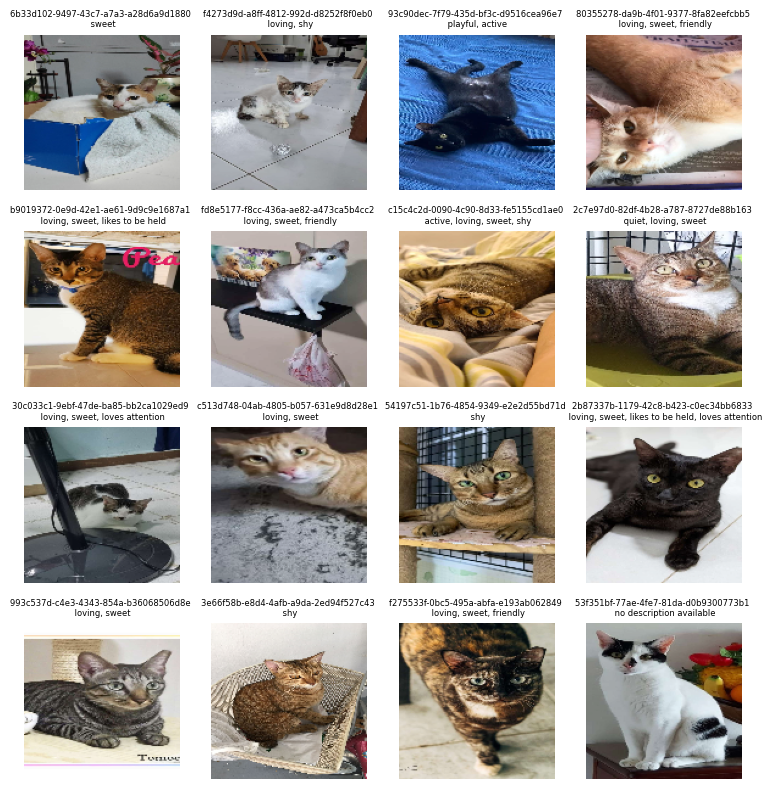

**************************************************************************************************************
                                  User 0153cd06-7ebb-41cc-b304-7b4e42c6b965                                   
                                            Recommended: 387 cats                                             
**************************************************************************************************************


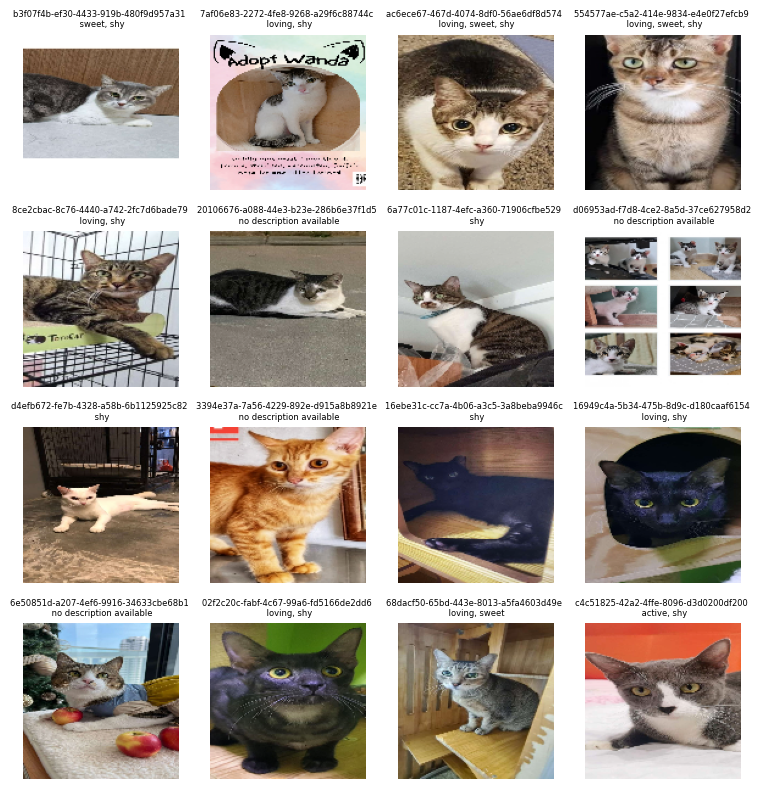

In [46]:
user = '0153cd06-7ebb-41cc-b304-7b4e42c6b965'

num_rated = len(rated[user])
num_recommended = len(recommendations[user])

print_width = 110

# Show user's rated items
print(f"*"*print_width)
print(f"User {user}".center(print_width))
print(f"Rated {num_rated} cats".center(print_width))
print(f"*"*print_width)
show_results(user, rated)


# Show recommended items to the user
print(f"*"*print_width)
print(f"User {user}".center(print_width))
print(f"Recommended: {num_recommended} cats".center(print_width))
print(f"*"*print_width)
show_results(user, recommendations)

### 4.3 Save output

In [47]:
df_output = pd.DataFrame(recommendations.items(), columns=['userID','catID'])

df_output.head()

,userID,catID
0,0153cd06-7ebb-41cc-b304-7b4e42c6b965,"[b3f07f4b-ef30-4433-919b-480f9d957a31, 7af06e8..."
1,01abb157-9112-47c6-9ff6-fb603505e341,"[ce290f5f-6b15-4831-98d0-6a003a2a0b04, 4bc6b51..."
2,029f1e2a-d68b-4801-869f-f422e925ae3d,"[481e7321-a4f1-4928-89d5-71737b26426c, ce290f5..."
3,079b0ec9-cec6-42fb-9f00-7891c52a10fb,"[ce290f5f-6b15-4831-98d0-6a003a2a0b04, 4bc6b51..."
4,081f358f-9624-468a-b6ef-f9b9fad2b3b3,"[ce290f5f-6b15-4831-98d0-6a003a2a0b04, 8035527..."


In [48]:
df_output.to_csv('../output/recommendations.csv', index=False)

## 5. References

<a id="f1">1</a>[^](#intext1) Eskandar, S. (2023, April 26). Exploring Feature Extraction Techniques for Natural Language Processing. Medium. https://medium.com/@eskandar.sahel/exploring-feature-extraction-techniques-for-natural-language-processing-46052ee6514

<a id="f2">2</a>[^](#intext2) Microsoft Corporation. (2018, January). Apply Diversity Metrics. GitHub. https://github.com/microsoft/recommenders/blob/0d2385681b2320f98d5ff0e448f505146b69df99/examples/03_evaluate/als_movielens_diversity_metrics.ipynb

<a id="f3">3</a>[^](#intext3) Microsoft Corporation. (2023). Recommenders. GitHub. https://github.com/recommenders-team/recommenders/commits/main/recommenders/evaluation/python_evaluation.py

<a id="f4">4</a>[^](#intext4) Yan, Ziyou. (2020, April). Serendipity: Accuracy’s Unpopular Best Friend in Recommenders. eugeneyan.com. https://eugeneyan.com/writing/serendipity-and-accuracy-in-recommender-systems/.

<a id="f5">5</a>[^](#intext5) Zhang, Y. C., Séaghdha, D. Ó., Quercia, D., & Jambor, T. (2012, February). Auralist: introducing serendipity into music recommendation. In Proceedings of the fifth ACM international conference on Web search and data mining (pp. 13-22).

 